# Import dependencies

In [58]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import speech_recognition as sr

In [59]:
data = pd.read_csv('tweet_emotions.csv')

In [60]:
data.head()

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


# Data cleaning

In [61]:
data.columns

Index(['tweet_id', 'sentiment', 'content'], dtype='object')

In [62]:
data.drop(['tweet_id'],inplace=True,axis=1)

In [63]:
data['sentiment'].value_counts()

neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: sentiment, dtype: int64

In [64]:
len(data['sentiment'].value_counts())

13

In [65]:
data.isnull().sum().sum()

0

# Data set preparation(converting text to numerical)

In [66]:
vocab_size = 1000
max_length = 70
embedding_dim = 16

In [67]:
tokenizer = Tokenizer(oov_token="<OOV>")

tokenizer.fit_on_texts(data['content'])
word_index = tokenizer.word_index
# Generate and pad the training sequences
sequences = tokenizer.texts_to_sequences(data['content'])
padded = pad_sequences(sequences,maxlen=max_length, truncating='post')

In [68]:
vocab_size = len(word_index)

In [69]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(data['sentiment'])

LabelEncoder()

In [70]:
data['emotion']=le.transform(data['sentiment'])

In [71]:
le.classes_

array(['anger', 'boredom', 'empty', 'enthusiasm', 'fun', 'happiness',
       'hate', 'love', 'neutral', 'relief', 'sadness', 'surprise',
       'worry'], dtype=object)

In [72]:
data.head()

,sentiment,content,emotion
0,empty,@tiffanylue i know i was listenin to bad habi...,2
1,sadness,Layin n bed with a headache ughhhh...waitin o...,10
2,sadness,Funeral ceremony...gloomy friday...,10
3,enthusiasm,wants to hang out with friends SOON!,3
4,neutral,@dannycastillo We want to trade with someone w...,8


In [73]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(data['emotion']).astype(int)
y[0]

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [74]:
train_size = int(data.shape[0]*0.9)
X_train = padded[:train_size]
y_train = y[:train_size]
X_test = padded[train_size:]
y_test = y[train_size:]

In [75]:
X_train[3]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 446,   3,
       720,  32,  23, 216, 176])

In [76]:
y_train[3]

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# Neural network for Multiple classification using LSTM

In [77]:
# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size,embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(13, activation='softmax')
])

# Setup the training parameters
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 70, 16)            783968    
                                                                 
 bidirectional_6 (Bidirectio  (None, 70, 256)          148480    
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 70, 128)          164352    
 nal)                                                            
                                                                 
 bidirectional_8 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                      

In [78]:
NUM_EPOCHS = 20

# Train the model
history = model.fit(X_train,y_train, epochs=NUM_EPOCHS, validation_data=(X_test,y_test))

Epoch 1/20
1125/1125 [==============================] - 53s 31ms/step - loss: 2.0581 - accuracy: 0.2772 - val_loss: 2.0119 - val_accuracy: 0.3285
Epoch 2/20
1125/1125 [==============================] - 33s 29ms/step - loss: 1.8370 - accuracy: 0.3756 - val_loss: 1.9433 - val_accuracy: 0.3503
Epoch 3/20
1125/1125 [==============================] - 37s 33ms/step - loss: 1.6292 - accuracy: 0.4466 - val_loss: 2.0838 - val_accuracy: 0.3395
Epoch 4/20
1125/1125 [==============================] - 37s 33ms/step - loss: 1.4123 - accuracy: 0.5168 - val_loss: 2.1977 - val_accuracy: 0.3307
Epoch 5/20
1125/1125 [==============================] - 36s 32ms/step - loss: 1.2139 - accuracy: 0.5960 - val_loss: 2.3762 - val_accuracy: 0.3165
Epoch 6/20
1125/1125 [==============================] - 36s 32ms/step - loss: 1.0374 - accuracy: 0.6645 - val_loss: 2.5699 - val_accuracy: 0.2865
Epoch 7/20
1125/1125 [==============================] - 36s 32ms/step - loss: 0.8807 - accuracy: 0.7166 - val_loss: 2.7982 -

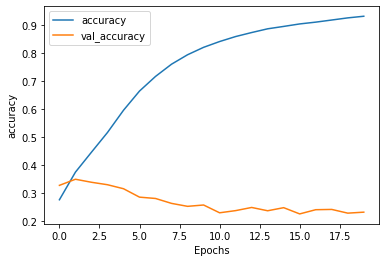

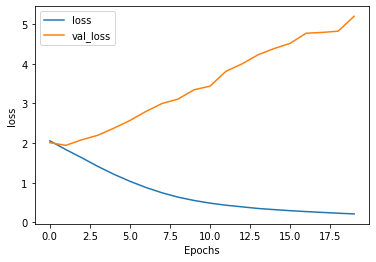

In [79]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy and results 
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [87]:
model.save('textemotion.h5')

In [94]:
model = tf.keras.models.load_model('textemotion.h5')

# Prediction on text and speech file

In [95]:
text4 = "charviray Charlene my love. I miss you"
data4 = [text4]
data4=tokenizer.texts_to_sequences(data4)
data4=pad_sequences(data4,maxlen=max_length,truncating='post')
prediction4 = model.predict(data4)
print(le.classes_[np.argmax(prediction4)])


sadness


In [96]:
r=sr.Recognizer()

In [97]:
with sr.AudioFile('speech3.wav') as source:
        audio = r.listen(source)
        try:
            text4 = r.recognize_google(audio)
            print(text4)
            data4 = [text4]
            data4=tokenizer.texts_to_sequences(data4)
            data4=pad_sequences(data4,maxlen=max_length,truncating='post')
            prediction4 = model.predict(data4)
            print(le.classes_[np.argmax(prediction4)])
            
        except:
            print('error in recognizing the file')

kids talking
neutral
